# 使用 Prophet 預測台股股價

## 載入相關套件

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from prophet import Prophet

## 載入資料集

In [2]:
START_DATE = '2020-01-01'
END_DATE = '2024-11-30'
CLOSE_FIELD_NAME = 'Close'
df = yf.download('^TWII', START_DATE, END_DATE)
df.tail(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^TWII,^TWII,^TWII,^TWII,^TWII
Date,,,,,
2024-11-18,22546.539062,22781.769531,22503.689453,22693.960938,3431100
2024-11-19,22848.800781,22906.689453,22578.750000,22614.740234,3689400
2024-11-20,22688.359375,22977.560547,22622.470703,22872.910156,3757700
2024-11-21,22555.660156,22708.570312,22490.279297,22671.660156,3395800
2024-11-22,22904.320312,23019.039062,22799.529297,22799.529297,3505100
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000


## 資料轉換

In [3]:
df.columns = [item[0] for item in df.columns]
df.tail(10)

,Close,High,Low,Open,Volume
Date,,,,,
2024-11-18,22546.539062,22781.769531,22503.689453,22693.960938,3431100
2024-11-19,22848.800781,22906.689453,22578.750000,22614.740234,3689400
2024-11-20,22688.359375,22977.560547,22622.470703,22872.910156,3757700
2024-11-21,22555.660156,22708.570312,22490.279297,22671.660156,3395800
2024-11-22,22904.320312,23019.039062,22799.529297,22799.529297,3505100
2024-11-25,22948.369141,23172.429688,22948.369141,22996.050781,5048900
2024-11-26,22678.759766,22832.109375,22645.130859,22789.599609,2985600
2024-11-27,22334.779297,22743.990234,22334.779297,22665.580078,3577000
2024-11-28,22298.900391,22413.250000,22124.310547,22380.449219,3123400


## 繪圖

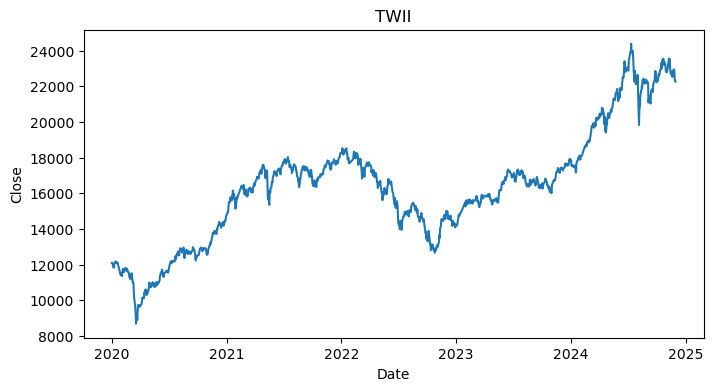

In [4]:
plt.figure(figsize=(8, 4))
sns.lineplot(x=df.index, y=CLOSE_FIELD_NAME, data=df)
plt.xlabel('Date')
plt.title('TWII');

In [5]:
df2 = df[[CLOSE_FIELD_NAME]].copy()
df2 = df2.reset_index()
dt_range = pd.date_range(start=START_DATE, end=END_DATE).to_frame(name='Date')
df2 = pd.merge(df2, dt_range, on='Date', how="right")
df2.tail(7)

,Date,Close
1789,2024-11-24,NaN
1790,2024-11-25,22948.369141
1791,2024-11-26,22678.759766
1792,2024-11-27,22334.779297
1793,2024-11-28,22298.900391
1794,2024-11-29,22262.500000
1795,2024-11-30,NaN


In [6]:
df2 = df2.ffill() # 以前一天填補 missing value
df2 = df2.bfill() # 以後一天填補 missing value
df2 = df2.set_index('Date') 
df2

,Close
Date,
2020-01-01,12100.480469
2020-01-02,12100.480469
2020-01-03,12110.429688
2020-01-04,12110.429688
2020-01-05,12110.429688
...,...
2024-11-26,22678.759766
2024-11-27,22334.779297
2024-11-28,22298.900391


## 資料分割

In [7]:
from sklearn.model_selection import train_test_split

df2 = df[[CLOSE_FIELD_NAME]].copy()

# 欄位改名
df2 = df2.reset_index()
df2.columns = ['ds', 'y'] 

# 資料分割
test_size=60
X_train, X_test = train_test_split(df2, test_size=test_size, shuffle=False)

# 查看陣列維度
X_train.shape, X_test.shape

((1133, 2), (60, 2))

## 模型訓練

In [8]:
X_train

,ds,y
0,2020-01-02,12100.480469
1,2020-01-03,12110.429688
2,2020-01-06,11953.360352
3,2020-01-07,11880.320312
4,2020-01-08,11817.099609
...,...,...
1128,2024-08-26,22240.119141
1129,2024-08-27,22185.000000
1130,2024-08-28,22370.660156
1131,2024-08-29,22201.849609


In [9]:
m = Prophet()
m.fit(X_train)

09:10:34 - cmdstanpy - INFO - Chain [1] start processing
09:10:34 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = m.make_future_dataframe(periods=test_size, freq = 'D')
predict = m.predict(future)
predict.tail(test_size)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1133,2024-08-31,22433.121004,22060.652091,23096.977476,22433.121004,22433.121004,149.623193,149.623193,149.623193,-90.791907,-90.791907,-90.791907,240.415099,240.415099,240.415099,0.0,0.0,0.0,22582.744197
1134,2024-09-01,22450.034655,22016.581540,23122.263555,22450.034655,22450.034655,145.263879,145.263879,145.263879,-90.791916,-90.791916,-90.791916,236.055795,236.055795,236.055795,0.0,0.0,0.0,22595.298534
1135,2024-09-02,22466.948306,22243.268057,23230.967436,22466.948306,22466.948306,251.335409,251.335409,251.335409,21.993078,21.993078,21.993078,229.342332,229.342332,229.342332,0.0,0.0,0.0,22718.283715
1136,2024-09-03,22483.861956,22195.427624,23298.596279,22483.861956,22483.861956,246.605994,246.605994,246.605994,26.425082,26.425082,26.425082,220.180912,220.180912,220.180912,0.0,0.0,0.0,22730.467951
1137,2024-09-04,22500.775607,22235.551518,23293.330556,22500.775607,22500.775607,257.837269,257.837269,257.837269,49.320888,49.320888,49.320888,208.516381,208.516381,208.516381,0.0,0.0,0.0,22758.612876
1138,2024-09-05,22517.689258,22230.261222,23316.250057,22517.689258,22517.689258,248.323409,248.323409,248.323409,53.991915,53.991915,53.991915,194.331494,194.331494,194.331494,0.0,0.0,0.0,22766.012667
1139,2024-09-06,22534.602909,22206.872072,23290.089447,22534.602909,22534.602909,207.498353,207.498353,207.498353,29.852860,29.852860,29.852860,177.645494,177.645494,177.645494,0.0,0.0,0.0,22742.101263
1140,2024-09-07,22551.516560,22114.902885,23156.573570,22551.516560,22551.516560,67.720150,67.720150,67.720150,-90.791907,-90.791907,-90.791907,158.512056,158.512056,158.512056,0.0,0.0,0.0,22619.236710
1141,2024-09-08,22568.430211,22116.383814,23152.176338,22568.430211,22568.430211,46.224752,46.224752,46.224752,-90.791916,-90.791916,-90.791916,137.016668,137.016668,137.016668,0.0,0.0,0.0,22614.654963
1142,2024-09-09,22585.343862,22185.476564,23304.037225,22585.343862,22585.343862,135.266593,135.266593,135.266593,21.993078,21.993078,21.993078,113.273516,113.273516,113.273516,0.0,0.0,0.0,22720.610455


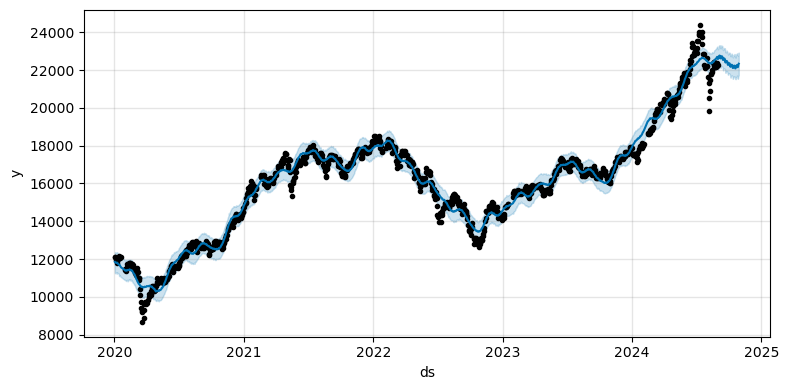

In [11]:
fig1 = m.plot(predict, figsize=(8, 4))

## 效應分解(Decomposition)

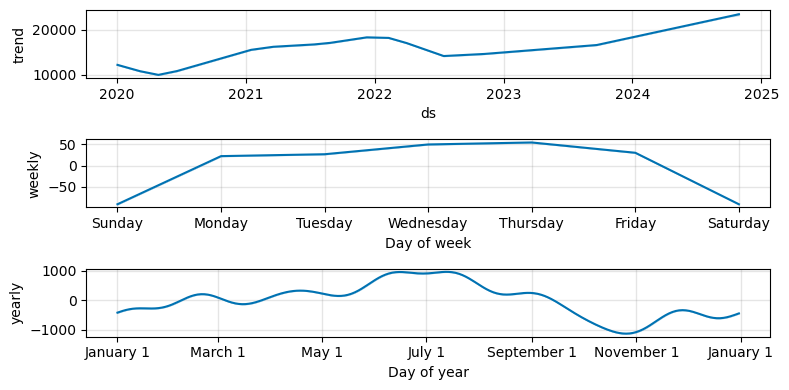

In [12]:
fig2 = m.plot_components(predict, figsize=(8, 4))

## 繪圖：比較實際值與預測值

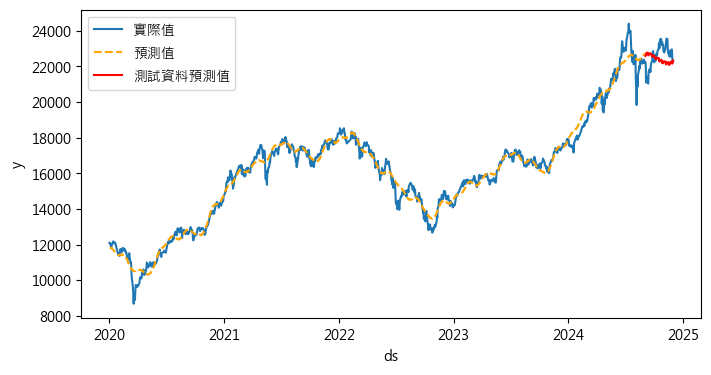

In [13]:
# 修正中文亂碼 
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8,4))
df2['predict'] = predict['yhat'].values
sns.lineplot(data=df2, x='ds', y='y', label='實際值')
# sns.lineplot(data=df2, x='ds', y='predict', label='預測值')
sns.lineplot(data=df2.iloc[1:-test_size], x='ds', y='predict', color='orange', label='預測值', linestyle='--')
sns.lineplot(data=df2.iloc[-test_size:], x='ds', y='predict', color='red', label='測試資料預測值')
plt.legend();
plt.legend();

In [14]:
df2['residual'] = df2['y'] - df2['predict']
print(f'MSE = {(np.sum(df2['residual']**2) / len(df2['residual'])):.2f}')

MSE = 200082.57


## 殘差(residual)繪圖

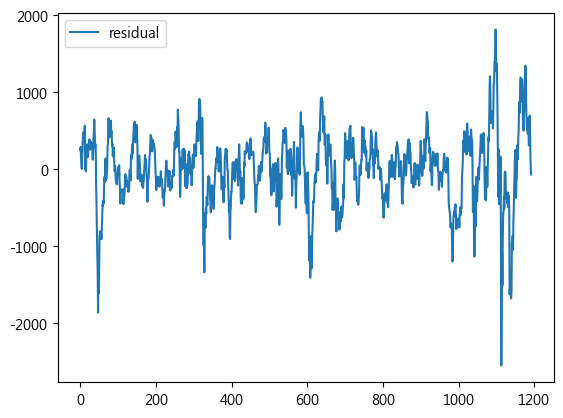

In [15]:
residuals = pd.DataFrame(df2['residual'])
residuals.plot();